In [17]:
import numpy as np
from matplotlib import pyplot as plt
from segmentation.segmenters import Segmenter, WaveletDecompositionModel, F1Loss, MangoOptimizer
from typing import List
from uschad import UscHadUser
import argparse
from tqdm import tqdm
import pandas as pd
import os
import pywt

In [2]:
DATASET = 'uschad'

parser = argparse.ArgumentParser()
# Checkpoint directory
parser.add_argument('--root_folder', type=str, default=f'data/{DATASET}/', help='Root folder for dataset')
parser.add_argument('--dataset', type=str, default=f'{DATASET}', help='The name of the dataset to use.')
parser.add_argument('--ws', type=int, default=100, help='Window size.')
parser.add_argument('--peak_tolerance', type=int, default=100, help='Peak tolerance for active learning.')
parser.add_argument('--level_wavelet', type=str, default=3, help='Level of the wavelet decomposition.')
parser.add_argument('--opt_max_calls', type=str, default=50, help='Optimizer max number of calls.')
parser.add_argument('--n_query', type=str, default=30, help='Maximum number of query for active learning.')

args = parser.parse_args("")

# Simulazioni

In [3]:
DIRECTORY = 'metrics/Call_6_6_2025/ablation/honeybee'

os.makedirs(name=DIRECTORY, exist_ok=True)

In [4]:
n_query = args.n_query
n_sequences = 6
n_reps = 10
total_runs = n_sequences * n_reps

# Preallocazione array per salvare le metriche di ogni run
all_precision = np.zeros((total_runs, n_query + 1))
all_recall    = np.zeros((total_runs, n_query + 1))
all_f1        = np.zeros((total_runs, n_query + 1))

run_idx = 0

for sequence in range(n_sequences):
    # Carica campioni e ground truth per ogni sequenza
    samples = np.load(f'{args.root_folder}sequence{sequence + 1}.npy')
    gt_break_points = np.load(f'{args.root_folder}labels{sequence + 1}.npy')
    # dataset = np.load(f'{args.root_folder}sequence{sequence+1}.npz') #babyecg_dataset

    # samples = dataset['original_samples']
    # gt_break_points = dataset['bkps']

    # Normalizza i campioni
    mu = samples.mean()
    sigma = samples.std()
    samples_norm = (samples - mu) / (3 * sigma)

    for rep in range(n_reps):

        print(f'### Sequence {sequence}, Repetition {rep+1} ###')
        # Array locali per questa singola run (sequence + rep)
        prec_run = np.zeros(n_query + 1)
        rec_run  = np.zeros(n_query + 1)
        f1_run   = np.zeros(n_query + 1)

        # Inizializza modello e segmenter
        score_model = WaveletDecompositionModel(
            samples_norm,
            windows_size=args.ws,
            level_wavelet=args.level_wavelet
        )
        segmenter = Segmenter(score_model=score_model)
        optimizer = MangoOptimizer(max_calls=args.opt_max_calls, regularization=0.0)
        loss = F1Loss(peak_tolerance=args.peak_tolerance, threshold=segmenter.threshold)
        segmenter.compile(loss, optimizer)

        # Calcola metriche iniziali (0 query)
        break_points = segmenter.get_break_points()
        precision, recall, f1 = segmenter.get_metrics(
            break_points=break_points,
            gt_break_points=gt_break_points
        )
        prec_run[0] = precision
        rec_run[0]  = recall
        f1_run[0]   = f1

        # Ciclo di active learning: ogni iterazione aggiunge fino a 2 query
        for q in range(n_query // 2):
            if f1 < 1:
                # Prendi gli indici meno certi
                indices = segmenter.get_least_certain()
                for index in indices:
                    start_idx = max(0, index - args.peak_tolerance)
                    end_idx   = min(len(samples_norm), index + args.peak_tolerance)
                    flag = False
                    for gt in gt_break_points:
                        if start_idx <= gt <= end_idx:
                            segmenter.add_break_point_to_gt(
                                gt,
                                supervised_interval=[start_idx, end_idx]
                            )
                            flag = True
                            break
                    if not flag:
                        segmenter.supervised_domain.add_interval([start_idx, end_idx])

                # Esegui l’aggiornamento del modello dopo un certo numero di query
                segmenter.update()

                # Ricalcola break points e metriche
                break_points = segmenter.get_break_points()
                precision, recall, f1 = segmenter.get_metrics(
                    break_points=break_points,
                    gt_break_points=gt_break_points
                )

                # Salva metrica dopo la 1ª query di questa iterazione
                prec_run[2 * q + 1] = precision
                rec_run[2 * q + 1]  = recall
                f1_run[2 * q + 1]   = f1
                prec_run[2 * (q + 1)] = precision
                rec_run[2 * (q + 1)]  = recall
                f1_run[2 * (q + 1)]   = f1

            else:
                # Se F1 è già perfetta, riempi il resto con 1
                prec_run[2 * q + 1] = 1
                rec_run[2 * q + 1]  = 1
                f1_run[2 * q + 1]   = 1
                prec_run[2 * (q + 1)] = 1
                rec_run[2 * (q + 1)]  = 1
                f1_run[2 * (q + 1)]   = 1

        # Memorizza i risultati di questa run
        all_precision[run_idx, :] = prec_run
        all_recall   [run_idx, :] = rec_run
        all_f1       [run_idx, :] = f1_run
        run_idx += 1

# Calcolo di media e deviazione standard lungo l’asse dei run
mean_precision = all_precision.mean(axis=0)
std_precision  = all_precision.std(axis=0)
mean_recall    = all_recall.mean(axis=0)
std_recall     = all_recall.std(axis=0)
mean_f1        = all_f1.mean(axis=0)
std_f1         = all_f1.std(axis=0)

# Prepara un array a 7 colonne: query, mean_prec, std_prec, mean_rec, std_rec, mean_f1, std_f1
x = np.arange(n_query + 1)
output_matrix = np.vstack([
    x,
    mean_precision,
    std_precision,
    mean_recall,
    std_recall,
    mean_f1,
    std_f1
]).T  # dimensione (n_query+1, 7)

# Salva su file di testo
output_file = f'{DIRECTORY}/ablation_no_expl.txt'
np.savetxt(
    output_file,
    output_matrix,
    fmt='%.6f',
    header='query mean_prec std_prec mean_rec std_rec mean_f1 std_f1',
    comments=''
)

print(f'File salvato: {output_file}')

### Sequence 0, Repetition 1 ###


Best loss: 2.506279675470303: 100%|██████████| 50/50 [00:02<00:00, 19.36it/s]


### Sequence 0, Repetition 2 ###


Best loss: 2.5336729816766117: 100%|██████████| 50/50 [00:04<00:00, 11.46it/s]


### Sequence 0, Repetition 3 ###


Best loss: 2.090072987906166: 100%|██████████| 50/50 [00:02<00:00, 18.06it/s]


### Sequence 0, Repetition 4 ###


Best loss: 2.4131566096049637: 100%|██████████| 50/50 [00:02<00:00, 18.28it/s]


### Sequence 0, Repetition 5 ###


Best loss: 2.4513013300408812: 100%|██████████| 50/50 [00:02<00:00, 18.36it/s]


### Sequence 0, Repetition 6 ###


Best loss: 2.593207315183668: 100%|██████████| 50/50 [00:03<00:00, 16.31it/s]


### Sequence 0, Repetition 7 ###


Best loss: 2.703556228842171: 100%|██████████| 50/50 [00:02<00:00, 18.70it/s]


### Sequence 0, Repetition 8 ###


Best loss: 2.268107992281357: 100%|██████████| 50/50 [00:02<00:00, 19.57it/s]


### Sequence 0, Repetition 9 ###


Best loss: 2.173696285574344: 100%|██████████| 50/50 [00:02<00:00, 17.06it/s]


### Sequence 0, Repetition 10 ###


Best loss: 2.235569405562229: 100%|██████████| 50/50 [00:02<00:00, 20.56it/s]


### Sequence 1, Repetition 1 ###


Best loss: 2.412750510354318: 100%|██████████| 50/50 [00:02<00:00, 16.90it/s]


### Sequence 1, Repetition 2 ###


Best loss: 2.830442123735559: 100%|██████████| 50/50 [00:02<00:00, 20.17it/s]


### Sequence 1, Repetition 3 ###


Best loss: 2.564014091329438: 100%|██████████| 50/50 [00:02<00:00, 21.12it/s]


### Sequence 1, Repetition 4 ###


Best loss: 2.2448396743873165: 100%|██████████| 50/50 [00:02<00:00, 17.36it/s]


### Sequence 1, Repetition 5 ###


Best loss: 2.3218214396763113: 100%|██████████| 50/50 [00:02<00:00, 19.74it/s]


### Sequence 1, Repetition 6 ###


Best loss: 2.7445925330939653: 100%|██████████| 50/50 [00:02<00:00, 21.48it/s]


### Sequence 1, Repetition 7 ###


Best loss: 2.599582204200146: 100%|██████████| 50/50 [00:04<00:00, 10.46it/s]


### Sequence 1, Repetition 8 ###


Best loss: 2.5551375431145424: 100%|██████████| 50/50 [00:02<00:00, 17.09it/s]


### Sequence 1, Repetition 9 ###


Best loss: 2.4896745502922646: 100%|██████████| 50/50 [00:02<00:00, 19.38it/s]


### Sequence 1, Repetition 10 ###


Best loss: 2.422693738317588: 100%|██████████| 50/50 [00:02<00:00, 20.53it/s] 


### Sequence 2, Repetition 1 ###


Best loss: 2.4911974532939833: 100%|██████████| 50/50 [00:02<00:00, 16.95it/s]


### Sequence 2, Repetition 2 ###


Best loss: 2.310623516470116: 100%|██████████| 50/50 [00:02<00:00, 18.80it/s]


### Sequence 2, Repetition 3 ###


Best loss: 2.30525463502205: 100%|██████████| 50/50 [00:02<00:00, 19.48it/s]


### Sequence 2, Repetition 4 ###


Best loss: 2.1391365913475706: 100%|██████████| 50/50 [00:02<00:00, 18.68it/s]


### Sequence 2, Repetition 5 ###


Best loss: 2.4677535651364924: 100%|██████████| 50/50 [00:02<00:00, 18.58it/s]


### Sequence 2, Repetition 6 ###


Best loss: 1.8281277284644382: 100%|██████████| 50/50 [00:02<00:00, 18.77it/s]


### Sequence 2, Repetition 7 ###


Best loss: 2.406207441828087: 100%|██████████| 50/50 [00:02<00:00, 17.96it/s]


### Sequence 2, Repetition 8 ###


Best loss: 2.5863006248832003: 100%|██████████| 50/50 [00:02<00:00, 18.60it/s]


### Sequence 2, Repetition 9 ###


Best loss: 2.0671790872589275: 100%|██████████| 50/50 [00:03<00:00, 16.37it/s]


### Sequence 2, Repetition 10 ###


Best loss: 2.289815052414988: 100%|██████████| 50/50 [00:02<00:00, 17.44it/s]


### Sequence 3, Repetition 1 ###


Best loss: 2.3538065065665634: 100%|██████████| 50/50 [00:03<00:00, 15.48it/s]


### Sequence 3, Repetition 2 ###


Best loss: 2.699489742783178: 100%|██████████| 50/50 [00:02<00:00, 17.57it/s]


### Sequence 3, Repetition 3 ###


Best loss: 2.610780065363823: 100%|██████████| 50/50 [00:02<00:00, 18.35it/s]


### Sequence 3, Repetition 4 ###


Best loss: 2.699489742783178: 100%|██████████| 50/50 [00:02<00:00, 19.37it/s]


### Sequence 3, Repetition 5 ###


Best loss: 2.5452231792995916: 100%|██████████| 50/50 [00:02<00:00, 20.35it/s]


### Sequence 3, Repetition 6 ###


Best loss: 2.699489742783178: 100%|██████████| 50/50 [00:02<00:00, 19.28it/s]


### Sequence 3, Repetition 7 ###


Best loss: 2.0234562268329945: 100%|██████████| 50/50 [00:02<00:00, 20.60it/s]


### Sequence 3, Repetition 8 ###


Best loss: 1.752297149302061: 100%|██████████| 50/50 [00:02<00:00, 20.13it/s]


### Sequence 3, Repetition 9 ###


Best loss: 2.4939902803074956: 100%|██████████| 50/50 [00:03<00:00, 14.94it/s]


### Sequence 3, Repetition 10 ###


Best loss: 2.699489742783178: 100%|██████████| 50/50 [00:02<00:00, 19.00it/s]


### Sequence 4, Repetition 1 ###


Best loss: 2.4430945998809945: 100%|██████████| 50/50 [00:02<00:00, 20.23it/s]


### Sequence 4, Repetition 2 ###


Best loss: 2.46165148284597: 100%|██████████| 50/50 [00:03<00:00, 16.03it/s]


### Sequence 4, Repetition 3 ###


Best loss: 2.4252443174875227: 100%|██████████| 50/50 [00:02<00:00, 19.63it/s]


### Sequence 4, Repetition 4 ###


Best loss: 2.2777192948377305: 100%|██████████| 50/50 [00:02<00:00, 16.90it/s]


### Sequence 4, Repetition 5 ###


Best loss: 2.2764378895035104: 100%|██████████| 50/50 [00:07<00:00,  6.76it/s]


### Sequence 4, Repetition 6 ###


Best loss: 2.363099581868724: 100%|██████████| 50/50 [00:02<00:00, 19.33it/s]


### Sequence 4, Repetition 7 ###


Best loss: 1.6570496364722427: 100%|██████████| 50/50 [00:02<00:00, 18.18it/s]


### Sequence 4, Repetition 8 ###


Best loss: 2.431263141853618: 100%|██████████| 50/50 [00:02<00:00, 21.77it/s]


### Sequence 4, Repetition 9 ###


Best loss: 2.4777870963248043: 100%|██████████| 50/50 [00:02<00:00, 18.20it/s]


### Sequence 4, Repetition 10 ###


Best loss: 2.6628261828236055: 100%|██████████| 50/50 [00:02<00:00, 19.90it/s]


### Sequence 5, Repetition 1 ###


Best loss: 1.9144057036440891: 100%|██████████| 50/50 [00:02<00:00, 17.74it/s]


### Sequence 5, Repetition 2 ###


Best loss: 2.1750497651152463: 100%|██████████| 50/50 [00:02<00:00, 17.67it/s]


### Sequence 5, Repetition 3 ###


Best loss: 2.273060647783401: 100%|██████████| 50/50 [00:02<00:00, 17.79it/s]


### Sequence 5, Repetition 4 ###


Best loss: 1.9505351384122096: 100%|██████████| 50/50 [00:02<00:00, 17.60it/s]


### Sequence 5, Repetition 5 ###


Best loss: 2.0664756587451345: 100%|██████████| 50/50 [00:02<00:00, 17.75it/s]


### Sequence 5, Repetition 6 ###


Best loss: 2.4848201436300044: 100%|██████████| 50/50 [00:03<00:00, 16.14it/s]


### Sequence 5, Repetition 7 ###


Best loss: 2.5355691255412443: 100%|██████████| 50/50 [00:02<00:00, 18.05it/s]


### Sequence 5, Repetition 8 ###


Best loss: 2.52412632621909: 100%|██████████| 50/50 [00:02<00:00, 17.17it/s]


### Sequence 5, Repetition 9 ###


Best loss: 2.1464876058497797: 100%|██████████| 50/50 [00:02<00:00, 18.38it/s]


### Sequence 5, Repetition 10 ###


Best loss: 1.7317047811283275: 100%|██████████| 50/50 [00:02<00:00, 17.78it/s]

File salvato: metrics/Call_6_6_2025/ablation/honeybee/ablation_no_expl.txt


In [ ]:
plt.figure(figsize=(12, 6))
f1_linea = np.loadtxt(f'{DIRECTORY}/ablation_linear_activation.txt')
f1_exp = np.loadtxt(f'{DIRECTORY}/ablation_argmin.txt')
plt.plot(f1_exp[:,-2])
plt.plot(f1_linea[:,-2])

# Test on BUGS

(67100, 3)

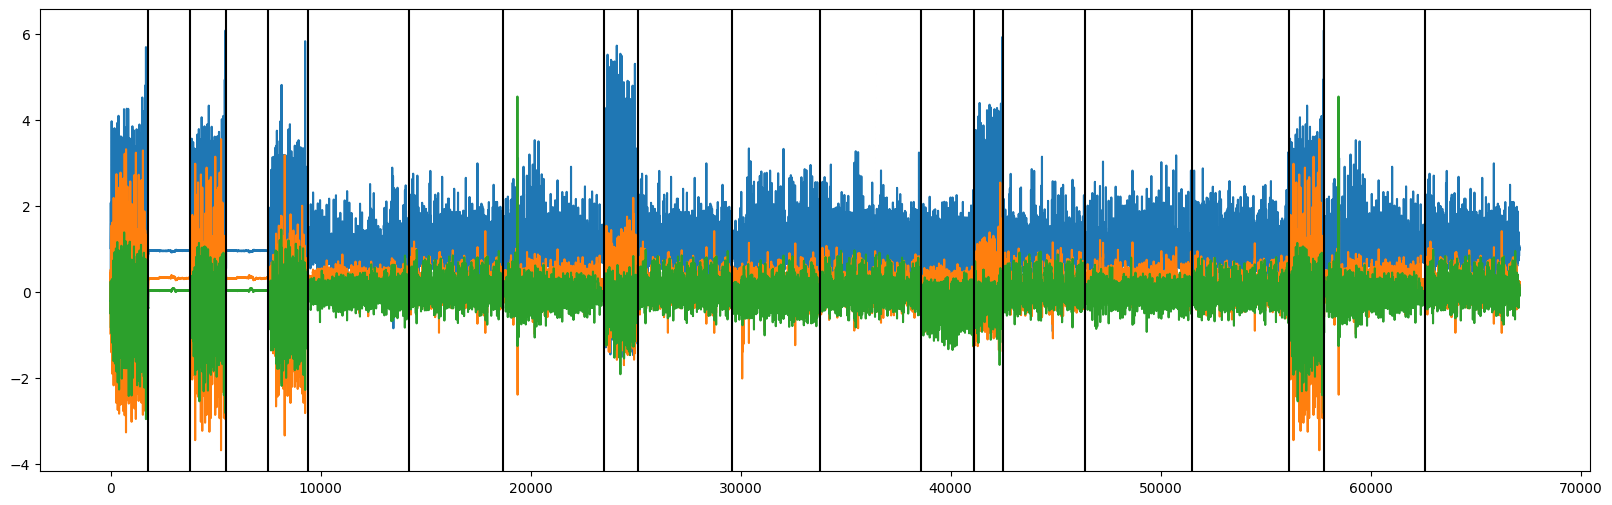

In [3]:
dataset = np.load(f'{args.root_folder}sequence0.npz') #babyecg_dataset

samples = dataset['original_samples']
gt_break_points = dataset['bkps']

# samples = np.load(f'{args.root_folder}sequence1.npy')[:,:50]
# gt_break_points = np.load(f'{args.root_folder}labels1.npy')
plt.figure(figsize=(20, 6))
plt.plot(samples)
for gt in gt_break_points:
    plt.axvline(gt, color='black')

samples.shape

In [11]:
from scipy.signal import resample
samples = resample(samples, 2000)

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(s)

In [ ]:
cA, cD = pywt.dwt(cA, 'db2', axis=0)

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(cA)

In [ ]:
np.savetxt('images/uschad/cDK.txt', cD)
np.savetxt('images/uschad/cAK.txt', cA)


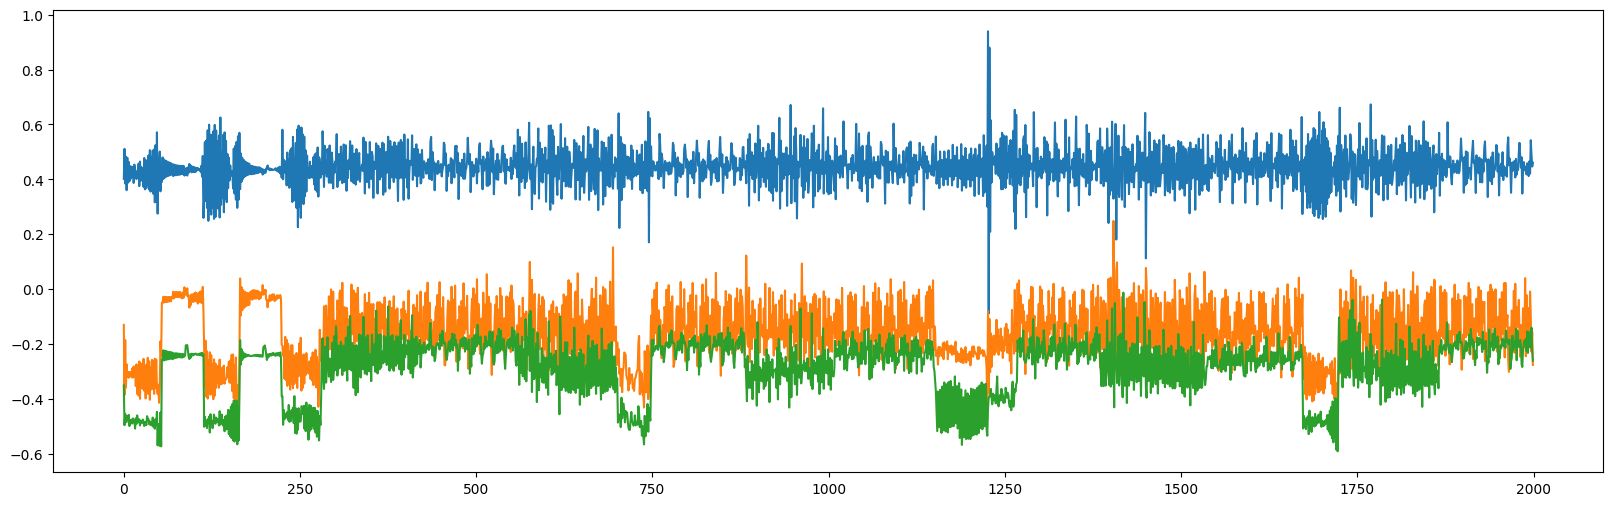

In [12]:
mu = samples.mean()
sigma = samples.std()
samples = (samples - mu)/(3*sigma) 

score_model = WaveletDecompositionModel(samples, windows_size=args.ws, level_wavelet=args.level_wavelet)
segmenter = Segmenter(score_model=score_model)
optimizer = MangoOptimizer(max_calls=args.opt_max_calls, regularization=1e-2)
loss = F1Loss(peak_tolerance=args.peak_tolerance, threshold=segmenter.threshold)
segmenter.compile(loss, optimizer)

break_points = segmenter.get_break_points()
plt.figure(figsize=(20, 6))
plt.plot(samples)
# for gt in gt_break_points:
#     plt.axvline(gt, color='black')
# for bkps in break_points:
#     plt.axvline(bkps, color='red', linestyle='--')

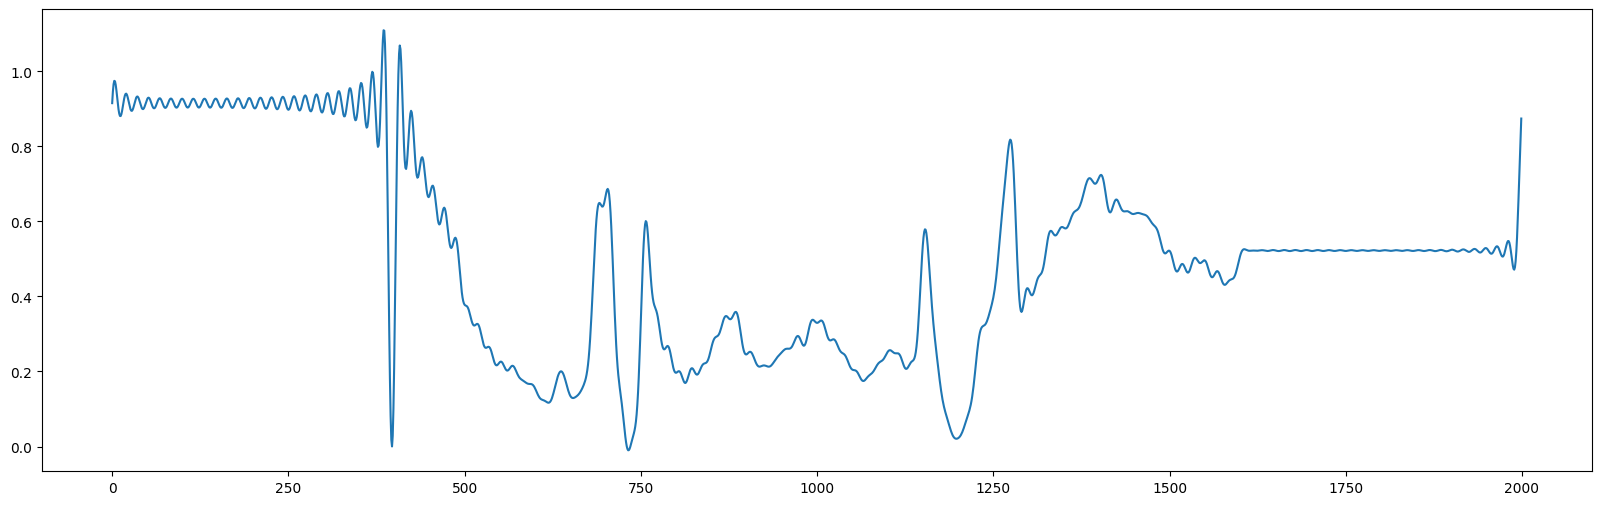

In [16]:
score = segmenter.score_model.resample_profile

plt.figure(figsize=(20, 6))
plt.plot(score[0].get_profile())

np.savetxt('images/uschad/f0.txt', score[3].get_profile())

In [ ]:
for score in segmenter.score_model.all_subband_profile:
    plt.figure(figsize=(20, 5))
    plt.plot(score.get_profile())
    for gt in gt_break_points:
        plt.axvline(gt, color='black', linestyle='dotted')

In [ ]:
s = resample(segmenter.score_model.average_profile.get_profile(), 2000)

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(s)

In [ ]:
np.savetxt('images/uschad/power.txt', s)

In [ ]:
for gt in gt_break_points[:3]:
    segmenter.add_break_point_to_gt(gt, supervised_interval=[gt-args.peak_tolerance, gt+args.peak_tolerance])
    segmenter.update()

In [ ]:
score_metric = []
precision, recall, f1 = segmenter.get_metrics(break_points=break_points, gt_break_points=gt_break_points)
print(f'  --/-- Metrics unsupervised model:     Precision = {precision},  Recall = {recall},  F1 = {f1} --/--')
score_metric.append(f1)

for q in range(args.n_query):
    unsupervised_score = segmenter.get_unsupervised_score()
    # if q == 0:
    #     index = segmenter.get_least_certain()
    # else:
    #     index = segmenter.get_optimal_candidate()

    # # index = segmenter.get_least_certain()
    # start_idx = max(0, index - args.peak_tolerance)
    # end_idx = min(len(samples), index + args.peak_tolerance)

    # flag = False
    # for gt in gt_break_points:
    #     if start_idx <= gt <= end_idx:
    #         print(f'Added the new gt break point {gt}')
    #         segmenter.add_break_point_to_gt(gt, supervised_interval=[start_idx, end_idx])
    #         # segmenter.update()
    #         flag = True
    #         break
    # # else...
    # if not flag:
    #     segmenter.supervised_domain.add_interval([start_idx, end_idx])
    #     # segmenter.update()

    indices = segmenter.get_least_certain()
    for index in indices: 
        start_idx = max(0, index - args.peak_tolerance)
        end_idx = min(len(samples), index + args.peak_tolerance)

        flag = False
        for gt in gt_break_points:
            if start_idx <= gt <= end_idx:
                print(f'Added the new gt break point {gt}')
                segmenter.add_break_point_to_gt(gt, supervised_interval=[start_idx, end_idx])
                flag = True
                break
        # else...
        if not flag:
            segmenter.supervised_domain.add_interval([start_idx, end_idx])

    if q > 10 and q%2:        
        segmenter.update()

    # get the new break points
    break_points = segmenter.get_break_points()
    precision, recall, f1 = segmenter.get_metrics(break_points=break_points, gt_break_points=gt_break_points)
    print(f'  --/-- Metrics after {q} query:     Precision = {precision},  Recall = {recall},  F1 = {f1} --/--\n')
    print(f'               ###############                  \n')
    score_metric.append(f1)

precision, recall, f1 = segmenter.get_metrics(break_points=break_points, gt_break_points=gt_break_points)
print(f'  --/-- Metrics after active loop:     Precision = {precision},  Recall = {recall},  F1 = {f1} --/--')

In [ ]:
break_points = segmenter.get_break_points()
plt.figure(figsize=(20, 6))
plt.plot(samples)
for gt in gt_break_points:
    plt.axvline(gt, color='black')
for bkps in break_points:
    plt.axvline(bkps, color='red', linestyle='--')

In [ ]:
dir = 'metrics/babyecg/test_babyecg_classic_lc.npy'

np.save(file=dir, arr=np.array(score_metric))

# Plot

## BabyECG

In [ ]:
assisted = pd.read_csv(filepath_or_buffer='metrics/Call_5_28_2025/babyecg/metrics.csv')
icpd = pd.read_csv(filepath_or_buffer='metrics/Call_5_28_2025/babyecg/metrics_icpd.csv')

plt.figure(figsize=(15, 6))
plt.plot(assisted['f1'][:92], label='assisted')
plt.plot(icpd[' f1'][:92], label='icpd')
plt.legend()

## HoneyBEE

In [ ]:
assisted = pd.read_csv(filepath_or_buffer='metrics/Call_5_28_2025/honeybee/metrics.csv')
icpd = pd.read_csv(filepath_or_buffer='metrics/Call_5_28_2025/honeybee/metrics_icpd.csv')

plt.figure(figsize=(15, 6))
plt.plot(assisted['f1'][:32], label='assisted')
plt.plot(icpd['f1'][:32], label='icpd')
plt.legend()

## ucihar


In [ ]:
assisted = pd.read_csv(filepath_or_buffer='metrics/Call_5_28_2025/ucihar/metrics.csv')
icpd = pd.read_csv(filepath_or_buffer='metrics/Call_5_28_2025/ucihar/metrics_icpd.csv')

plt.figure(figsize=(15, 6))
plt.plot(assisted['f1'][:100], label='assisted')
plt.plot(icpd['f1'][:100], label='icpd')
plt.legend()

## USC-HAD

In [ ]:
v2 = pd.read_csv(filepath_or_buffer='metrics/Call_5_23_2025/uschad/metrics.csv')['f1']
v3 = pd.read_csv(filepath_or_buffer='metrics/Call_5_26_2025/uschad/metrics.csv')['f1']

plt.figure(figsize=(12, 6))
plt.plot(v2, label='v2')
plt.plot(v3, label='v3')
plt.legend()